### 1.GAN概述

GAN包含有两个模型，一个是生成模型（generative model），一个是判别模型(discriminative model)。生成模型的任务是生成看起来自然真实的、和原始数据相似的实例。判别模型的任务是判断给定的实例看起来是自然真实的还是人为伪造的（真实实例来源于数据集，伪造实例来源于生成模型）。
论文采用类比的手法通俗理解：生成模型像“一个造假团伙，试图生产和使用假币”，而判别模型像“检测假币的警察”。生成器（generator）试图欺骗判别器（discriminator），判别器则努力不被生成器欺骗。模型经过交替优化训练，两种模型都能得到提升，但最终我们要得到的是效果提升到很高很好的生成模型（造假团伙），这个生成模型（造假团伙）所生成的产品能达到真假难分的地步。

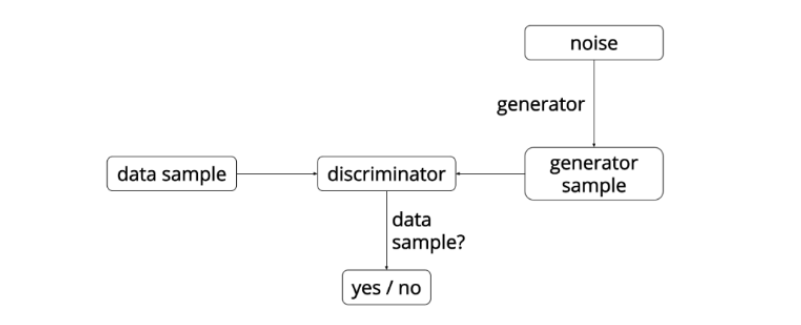

结合整体模型图示，再以生成图片作为例子具体说明下面。我们有两个网络，G（Generator）和D（Discriminator）。Generator是一个生成图片的网络，它接收一个随机的噪声z，通过这个噪声生成图片，记做G(z)。Discriminator是一个判别网络，判别一张图片是不是“真实的”。它的输入是x，x代表一张图片，输出D（x）代表x为真实图片的概率，如果为1，就代表100%是真实的图片，而输出为0，就代表不可能是真实的图片。

### 2.GAN模型优化训练

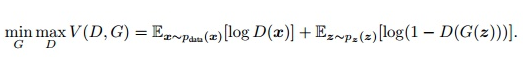

在这里，训练网络D使得最大概率地分对训练样本的标签(最大化log D(x)和log(1 - D(G(z))))，训练网络G最小化log(1 – D(G(z)))，即最大化D的损失。而训练过程中固定一方，更新另一个网络的参数，交替迭代，使得对方的错误最大化，最终，G 能估测出样本数据的分布，也就是生成的样本更加的真实。

***　或者就是可以直接理解成G网络的loss是log(1-D(G(z))),而D的loss是-(log(D(x))+log(1-D(G(z))))

然后从式子中解释对抗，我们知道G网络的训练是希望D(G(z))趋近于1，也就是正类，这样G的loss就会最小。而D网络的训练就是一个2分类，目标是分清楚真实数据和生成数据，也就是希望真实数据的D输出趋近于1，而生成数据的输出即D(G(z))趋近于0，或是负类。这里就是体现了对抗的思想。

### 3.GAN的经典变种

####　WGAN和WGAN-GP

WGAN也是一篇经典，WGAN主要从损失函数的角度对GAN做了改进，损失函数改进之后的WGAN即使在全链接层上也能得到很好的表现结果

#### DCGAN

DCGAN是继GAN之后比较好的改进，其主要的改进主要是在网络结构上，开创性地将CNN和GAN相结合以实现对图像的处理。到目前为止，DCGAN的网络结构还是被广泛的使用，DCGAN极大的提升了GAN训练的稳定性以及生成结果质量。

#### Conditional GAN

因为原始的GAN过于自由，训练会很容易失去方向，从而导致不稳定又效果差。而Conditional GAN就是在原来的GAN模型中加入一些先验条件，使得GAN变得更加的可控制。具体的来说，就是可以在生成模型G和判别模型D中同时加入条件约束y来引导数据的生成过程。条件可以是任何补充的信息，如类标签，其它模态的数据等。然后这样的做法应用也很多，比如图像标注，利用text生成图片或者是训练音频，听到猫叫声来生成小猫图片等等。

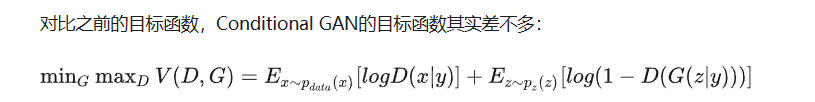

#### 4.GAN代码

In [ ]:
import argparse
import os
import numpy as np
import torchvision.transforms as transforms
from torchvision.utils import save_image
from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable
import torch.nn as nn
import torch

## 创建文件夹
os.makedirs("./images/gan/", exist_ok=True)         ## 记录训练过程的图片效果
os.makedirs("./save/gan/", exist_ok=True)           ## 训练完成时模型保存的位置
os.makedirs("./datasets/mnist", exist_ok=True)      ## 下载数据集存放的位置

## 超参数配置
parser = argparse.ArgumentParser()
parser.add_argument("--n_epochs", type=int, default=50, help="number of epochs of training")
parser.add_argument("--batch_size", type=int, default=64, help="size of the batches")
parser.add_argument("--lr", type=float, default=0.0002, help="adam: learning rate")
parser.add_argument("--b1", type=float, default=0.5, help="adam: decay of first order momentum of gradient")
parser.add_argument("--b2", type=float, default=0.999, help="adam: decay of first order momentum of gradient")
parser.add_argument("--n_cpu", type=int, default=2, help="number of cpu threads to use during batch generation")
parser.add_argument("--latent_dim", type=int, default=100, help="dimensionality of the latent space")
parser.add_argument("--img_size", type=int, default=28, help="size of each image dimension")
parser.add_argument("--channels", type=int, default=1, help="number of image channels")
parser.add_argument("--sample_interval", type=int, default=500, help="interval betwen image samples")
opt = parser.parse_args()
## opt = parser.parse_args(args=[])                 ## 在colab中运行时，换为此行
print(opt)

## 图像的尺寸:(1， 28， 28),  和图像的像素面积:(784)
img_shape = (opt.channels, opt.img_size, opt.img_size)
img_area = np.prod(img_shape)

## 设置cuda:(cuda:0)
cuda = True if torch.cuda.is_available() else False

## mnist数据集下载
mnist = datasets.MNIST(
    root='./datasets/', train=True, download=True, transform=transforms.Compose(
            [transforms.Resize(opt.img_size), transforms.ToTensor(), transforms.Normalize([0.5], [0.5])]
        ), 
)

## 配置数据到加载器
dataloader = DataLoader(
    mnist,
    batch_size=opt.batch_size,
    shuffle=True,
)

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(img_area, 512),                   
            nn.LeakyReLU(0.2, inplace=True),            
            nn.Linear(512, 256),                        
            nn.LeakyReLU(0.2, inplace=True),            
            nn.Linear(256, 1),                         
            nn.Sigmoid(),                               
        )

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)            
        validity = self.model(img_flat)                 
        return validity                                

In [ ]:
## ###### 定义生成器 Generator #####
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        ## 模型中间块儿
        def block(in_feat, out_feat, normalize=True):          
            layers = [nn.Linear(in_feat, out_feat)]             
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))    
            layers.append(nn.LeakyReLU(0.2, inplace=True))      
            return layers
       
        self.model = nn.Sequential(
            *block(opt.latent_dim, 128, normalize=False),      
            *block(128, 256),                                   
            *block(256, 512),                                   
            *block(512, 1024),                                  
            nn.Linear(1024, img_area),                          
            nn.Tanh()                                           
        )
    
    def forward(self, z):                                      
        imgs = self.model(z)                                     
        imgs = imgs.view(imgs.size(0), *img_shape)                 
        return imgs                                             

In [ ]:
generator = Generator()
discriminator = Discriminator()
criterion = torch.nn.BCELoss()
optimizer_G = torch.optim.Adam(generator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))
if torch.cuda.is_available():
    generator = generator.cuda()
    discriminator = discriminator.cuda()
    criterion = criterion.cuda()

In [ ]:
##  Training
## ----------
## 进行多个epoch的训练
for epoch in range(opt.n_epochs):                               
    for i, (imgs, _) in enumerate(dataloader):               
        
        ## =============================训练判别器==================
        imgs = imgs.view(imgs.size(0), -1)                          
        real_img = Variable(imgs).cuda()                            
        real_label = Variable(torch.ones(imgs.size(0), 1)).cuda()      
        fake_label = Variable(torch.zeros(imgs.size(0), 1)).cuda()     
        real_out = discriminator(real_img)                         
        loss_real_D = criterion(real_out, real_label)               
        real_scores = real_out                                      
        z = Variable(torch.randn(imgs.size(0), opt.latent_dim)).cuda()      
        fake_img = generator(z).detach()                                    
        fake_out = discriminator(fake_img)                                  
        loss_fake_D = criterion(fake_out, fake_label)                       
        fake_scores = fake_out                                              
        ## 损失函数和优化
        loss_D = loss_real_D + loss_fake_D                 
        optimizer_D.zero_grad()                             
        loss_D.backward()                                   
        optimizer_D.step()                                  


        z = Variable(torch.randn(imgs.size(0), opt.latent_dim)).cuda()      
        fake_img = generator(z)                                            
        output = discriminator(fake_img)                                    
        ## 损失函数和优化
        loss_G = criterion(output, real_label)                              
        optimizer_G.zero_grad()                                             
        loss_G.backward()                                                   
        optimizer_G.step()                                                  

        if (i + 1) % 100 == 0:
            print(
                "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f] [D real: %f] [D fake: %f]"
                % (epoch, opt.n_epochs, i, len(dataloader), loss_D.item(), loss_G.item(), real_scores.data.mean(), fake_scores.data.mean())
            )
        ## 保存训练过程中的图像
        batches_done = epoch * len(dataloader) + i
        if batches_done % opt.sample_interval == 0:
            save_image(fake_img.data[:25], "./images/gan/%d.png" % batches_done, nrow=5, normalize=True)

## 保存模型
torch.save(generator.state_dict(), './save/gan/generator.pth')
torch.save(discriminator.state_dict(), './save/gan/discriminator.pth')

#### Conditional GAN

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
 
        self.label_emb = nn.Embedding(10,10) 
        #Embedding类返回的是一个形状为[每句词个数， 词维度]的矩阵。
 
 
        self.model = nn.Sequential(
            nn.Linear(794,1024),
            nn.LeakyReLU(0.2,inplace=True),
            nn.Dropout(0.4),
            nn.Linear(1024,512),
            nn.LeakyReLU(0.2,inplace=True),
            nn.Dropout(0.4),
            nn.Linear(512,256),
            nn.LeakyReLU(0.2,inplace=True),
            nn.Dropout(0.4),
            nn.Linear(256,1),
            nn.Sigmoid()
        )
 
    def forward(self,x,labels):
        x = x.view(x.size(0),784)
        c = self.label_emb(labels)
        x = torch.cat([x,c],1)
        out = self.model(x)
        return out.squeeze()

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
 
        self.label_emb = nn.Embedding(10,10)
 
        self.model = nn.Sequential(
            nn.Linear(110,256),
            nn.LeakyReLU(0.2,inplace=True),
            nn.Linear(256,512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 784),
            nn.Tanh()
        )
    def forward(self,z,labels):
        z = z.view(z.size(0),100)
        c = self.label_emb(labels)
        x = torch.cat([z,c],1)
        out = self.model(x)

conditional gan的代码与传统的gan的差别就是concat了条件